In [2]:
import PyHeston # The PyHeston package must be installed.
import numpy
import itertools

from BlackScholes import *
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv
import math

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
nInt = 1024
r0 = 0.0002
S= 100
K = 100
#T = 0.01
r = r0
sigma = 0.1 #0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
T = 2.0

In [4]:
training_number = 30 # change training size 
testing_number = 40   #use all data as test, otherwise shape not match


x1_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.05,1.0, training_number), dtype='float32').reshape(training_number, 1)


X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:,0] = X1_train.flatten()
x_train[:,1] = X2_train.flatten()

In [5]:

#x1_test = torch.linspace(0, 1.0, testing_number)
#x2_test = torch.linspace(0.05, 1.0, testing_number)
x1_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

In [6]:
nt = 11
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)

In [7]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        print(time)
        
        y_train = []
        
        for idx in range(len(x_train)):
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_train.append(f(x_train[idx,0], x_train[idx,1], time))
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [8]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
                
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_test_.append(f(x_test[idx,0], x_test[idx,1], time))
            
        print(len(x_test), len(y_test_))
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [9]:
lb = 1
ub = 400
portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y,z: PyHeston.HestonCall(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)
portfolio['put']['price']= lambda x,y,z: PyHeston.HestonPut(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)

In [10]:
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

[0.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.27282331]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-12.05142684]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


[0.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-366.1731698]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17.71348198]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0336636]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

[0.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-45.59273056]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-17.94817497]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.54921035]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 137, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

[0.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-397.47746617]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.56536889]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04018092]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/

[0.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([99.0514136]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 101, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-483.34255564]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.26461238]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/

[1.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-68.64703159]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.40317081]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-96.73759563]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/

[1.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.99361822]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-69.60840222]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-213.43726552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

[1.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01581895]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([27.97544914]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.91222596]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

[1.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00029206]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.48196745]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01735687]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

[1.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.42025197]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.08739454]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.13124007]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr

[2.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.30843902]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.48327875]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([14.8009702]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr

1600 1600
1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600
[0.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[0.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.03406363]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


[0.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.20177721]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01753542]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00985595]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

[0.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-10.42022005]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.17795779]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.07763294]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

[0.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59992832]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.1283527]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.31792566]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr

[1.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.76353768]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.34142162]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.601641]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.p

[1.2]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.10536544]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00079731]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.05627849]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.

[1.4]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.14412166]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.62007255]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 127, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.13712652]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr

[1.6]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.5045618]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.70377848]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.1669268]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.

[1.8]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.02832938]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.50448303]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00323989]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.

[2.]


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.25707206]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.08277535]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.67512494]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

1600 1600
1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1600 1600


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


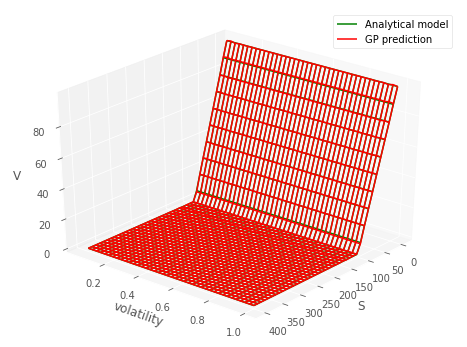

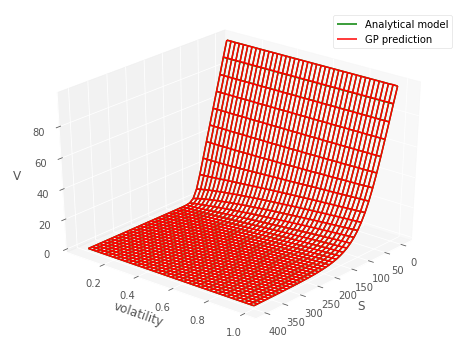

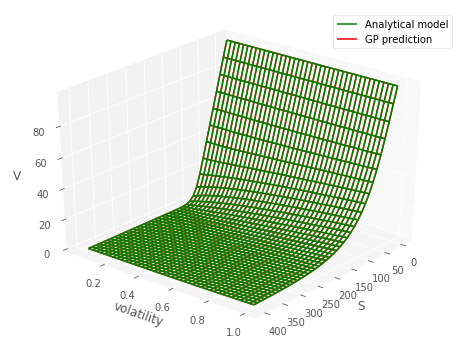

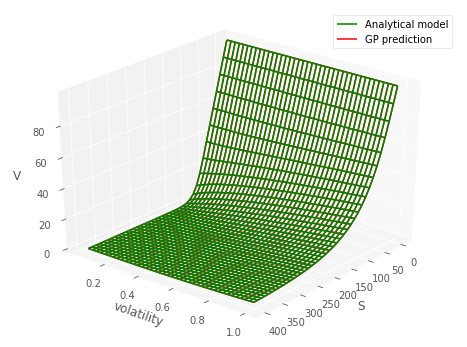

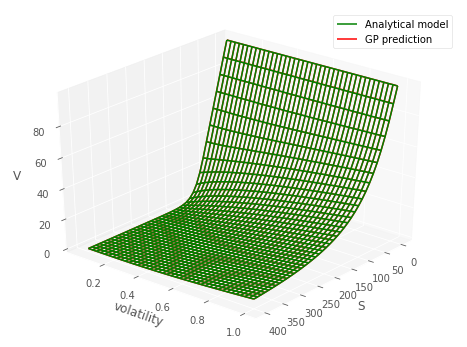

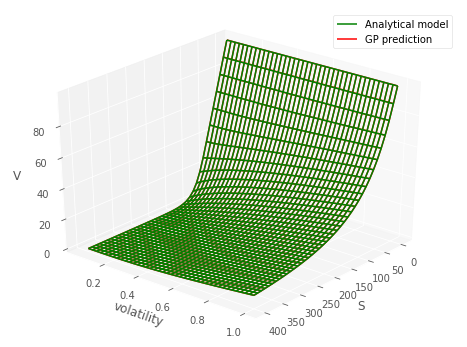

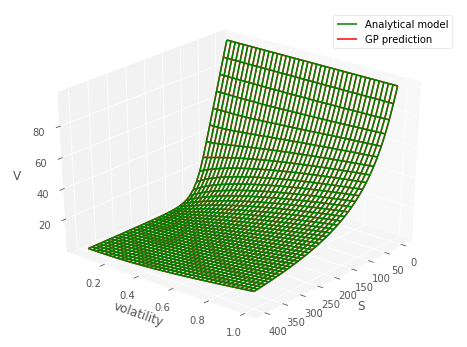

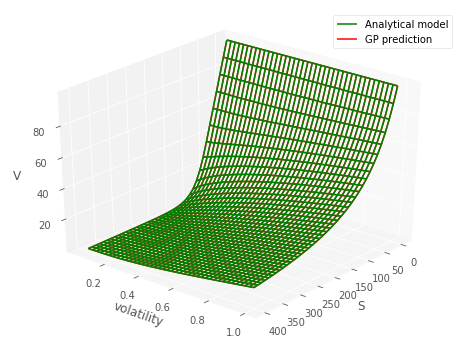

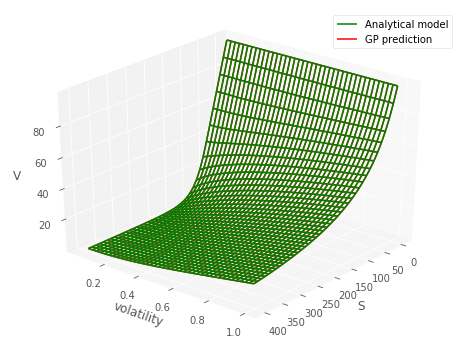

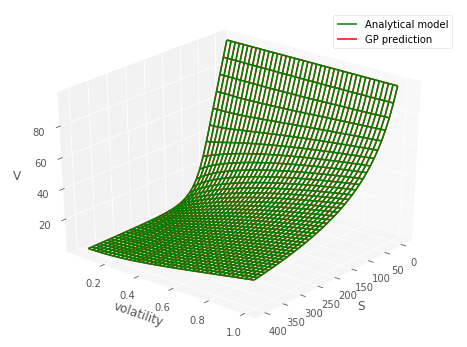

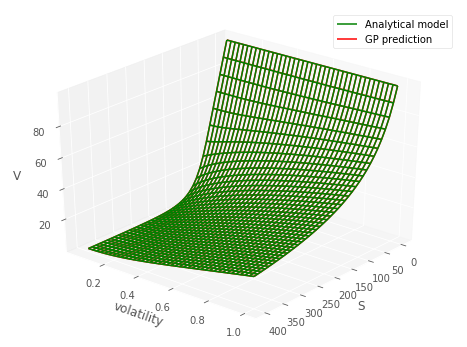

In [16]:
# plot the GP versus the testing data for each point on the timegrid

res = testing_number

x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=x_test[:,1].reshape(res,res)

for t in range(len(timegrid)):
    
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = plt.axes(projection='3d')


    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})

    pred_plot  =  portfolio['put']['preds'][t].reshape(res,res) 
    test_plot = portfolio['put']['y_tests'][t].reshape(res,res) 

    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Analytical model')
    ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP prediction' )
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})
